In [0]:
%pip install bokeh

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
dbutils.fs.ls("/FileStore/tables/")

Out[1]: [FileInfo(path='dbfs:/FileStore/tables/accounts/', name='accounts/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/accounts-1.zip', name='accounts-1.zip', size=5297592, modificationTime=1645026603000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-2.zip', name='accounts-2.zip', size=5297592, modificationTime=1647878306000),
 FileInfo(path='dbfs:/FileStore/tables/accounts-3.zip', name='accounts-3.zip', size=5297592, modificationTime=1647940218000),
 FileInfo(path='dbfs:/FileStore/tables/accounts.zip', name='accounts.zip', size=5297592, modificationTime=1645026541000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2019_csv.gz', name='clinicaltrial_2019_csv.gz', size=10060669, modificationTime=1650985353000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2020_csv.gz', name='clinicaltrial_2020_csv.gz', size=10981608, modificationTime=1650985356000),
 FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021/', name='clinicaltrial_2021/', size=0,

In [0]:
#Naming the CSV files 

clinicaltrial_2021= ('dbfs:/FileStore/tables/clinicaltrial_2021.csv')
mesh= ('dbfs:/FileStore/tables/mesh.csv')
pharma= ('dbfs:/FileStore/tables/pharma.csv')

In [0]:
#Importing CSV file of clinicaltrial_2021 

import csv
Clinicaltrial_2021_RDD = sc.textFile(clinicaltrial_2021)
header = Clinicaltrial_2021_RDD.first()
Clinicaltrial_2021_RDD = Clinicaltrial_2021_RDD.filter(lambda y: y != header) 

In [0]:
#Importing CSV file of mesh 

import csv
Mesh_RDD = sc.textFile(mesh)
header = Mesh_RDD.first()
Mesh_RDD = Mesh_RDD.filter(lambda y: y != header).mapPartitions(lambda y: csv.reader(y))

In [0]:
#Importing CSV file of pharma 

import csv
Pharma_RDD = sc.textFile(pharma)
header = Pharma_RDD.first()
Pharma_RDD = Pharma_RDD.filter(lambda y: y != header).mapPartitions(lambda y: csv.reader(y))

In [0]:
#Q1 = "The number of studies in the dataset. You must ensure that you explicitly check distinct studies."

Q1 = Clinicaltrial_2021_RDD.map(lambda y: y.split('|')) 
Q1.count()

Out[12]: 387262

In [0]:
#Q2 = "You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. These should be ordered from most frequent to least frequent."

RDD3 = Q1.map(lambda y: (y[5], 1))
RDD4 = RDD3.reduceByKey(lambda y,z: y+z)
RDD5 = RDD4.map(lambda y: (y[1], y[0]))
RDD6 = RDD5.sortByKey(False)
Q2 = RDD6.filter(lambda y: y[1] != "")
Q2.take(5)

Out[18]: [(301472, 'Interventional'),
 (77540, 'Observational'),
 (8180, 'Observational [Patient Registry]'),
 (69, 'Expanded Access'),
 (1, 'Type')]

In [0]:
#Q3 = "The top 5 conditions (from Conditions) with their frequencies." 
  
Q3= Q1.filter(lambda y: y[7] != "").map(lambda y: (y[0], y[7].split(","))).flatMapValues(lambda y: y).map(lambda y: (y[1].strip(), 1)).reduceByKey(lambda y,z: y+z).map(lambda y: (y[1], y[0])).sortByKey(False).filter(lambda y: y[1] != "")

In [0]:
Q3.take(5)

Out[20]: [(13389, 'Carcinoma'),
 (11080, 'Diabetes Mellitus'),
 (9371, 'Neoplasms'),
 (8640, 'Breast Neoplasms'),
 (8032, 'Syndrome')]

In [0]:
#Q4 = "Each condition can be mapped to one or more hierarchy codes. The client wishes to know the 5 most frequent roots (i.e. the sequence of letters and numbers before the first full stop) after this is done."

Mesh = Mesh_RDD.map(lambda y: (y[0].strip(), y[1].split(".")[0])).map(lambda y: (y[0], y[1])).groupByKey().map(lambda y: (y[0], list(y[1])))

In [0]:
Clinicaltrial_2021 = Q1.map(lambda y: (y[0], y[7].split(","))).flatMapValues(lambda y: y).filter(lambda y: y[1] != '').map(lambda y: (y[1].strip(), y[0])).map(lambda y: (y[0], y[1]))

In [0]:
Clinicaltrial_2021_Mesh = Clinicaltrial_2021.join(Mesh)
y = Clinicaltrial_2021_Mesh.map(lambda y: (y[1][0], y[1][1])).flatMapValues(lambda y: y).map(lambda y: (y[1], 1)).reduceByKey(lambda y,z: y+z).map(lambda y: (y[1], y[0])).sortByKey(False)

In [0]:
y.take(5)

Out[24]: [(143994, 'C04'),
 (136079, 'C23'),
 (106674, 'C01'),
 (94523, 'C14'),
 (92310, 'C10')]

In [0]:
y.take(10)

Out[26]: [(143994, 'C04'),
 (136079, 'C23'),
 (106674, 'C01'),
 (94523, 'C14'),
 (92310, 'C10'),
 (85646, 'C06'),
 (70720, 'C08'),
 (42599, 'C13'),
 (41276, 'C18'),
 (40161, 'C12')]

In [0]:
#Q5 = "Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored. Hint: For a basic implementation, you can assume that the Parent Company column contains all possible pharmaceutical companies." 

A = Pharma_RDD.map(lambda y: y[1].strip())

In [0]:
Q5 = set(A.collect())
Q1.map(lambda y: (y[1].strip(), y[0])).filter(lambda y: y[0] not in Q5).groupByKey().map(lambda y: (len(y[1]), y[0])).sortByKey(False).take(10)

Out[28]: [(3218, 'National Cancer Institute (NCI)'),
 (2414, 'M.D. Anderson Cancer Center'),
 (2369, 'Assistance Publique - Hôpitaux de Paris'),
 (2300, 'Mayo Clinic'),
 (2243, 'Merck Sharp & Dohme Corp.'),
 (2154, 'Assiut University'),
 (2088, 'Novartis Pharmaceuticals'),
 (1971, 'Massachusetts General Hospital'),
 (1928, 'Cairo University'),
 (1828, 'Hoffmann-La Roche')]

In [0]:
#Q6 = "Plot number of completed studies each month in a given year – for the submission dataset, the year is 2021. You need to include your visualization as well as a table of all the values you have plotted for each month"

Q6 = Q1.filter(lambda y: y[2] == 'Completed').filter(lambda y: y[4] != '').map(lambda y: y[4].split()).filter(lambda y: y[1] == '2021').map(lambda y: (y[0], y[1])).groupByKey().map(lambda y: (y[0], len(y[1])))

In [0]:
Q6.collect()

Out[30]: [('May', 984),
 ('Jan', 1131),
 ('Jun', 1094),
 ('Mar', 1227),
 ('Feb', 934),
 ('Aug', 700),
 ('Apr', 967),
 ('Jul', 819),
 ('Oct', 187),
 ('Sep', 528)]

In [0]:
#To visualize using line plots in Matplotlib 

import pandas as pd
import numpy as np 

In [0]:
frequency = dict(Q6.collect())
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct']
visaulisation = []
for m in months:
 y = (m, frequency[m])
 visaulisation.append(y)
print(visaulisation)

[('Jan', 1131), ('Feb', 934), ('Mar', 1227), ('Apr', 967), ('May', 984), ('Jun', 1094), ('Jul', 819), ('Aug', 700), ('Sep', 528), ('Oct', 187)]


In [0]:
RDD = sc.parallelize(visaulisation)

In [0]:
RDD.collect()

Out[34]: [('Jan', 1131),
 ('Feb', 934),
 ('Mar', 1227),
 ('Apr', 967),
 ('May', 984),
 ('Jun', 1094),
 ('Jul', 819),
 ('Aug', 700),
 ('Sep', 528),
 ('Oct', 187)]

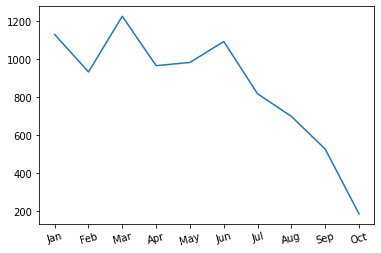

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
z = RDD.map(lambda y: y[1]).collect()
y = RDD.map(lambda y: y[0]).collect()
plt.plot(y, z)
plt.xticks(rotation = 15)
plt.show()